In [93]:
# pyg-team
# from: https://paperswithcode.com/paper/variational-graph-normalized-auto-encoders

In [94]:
import os.path as ospath
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.nn import Linear, LeakyReLU
from sklearn.metrics import roc_auc_score
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.data import Data, Dataset
import torch_geometric.transforms as T

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## load data

In [95]:
prefix1 = 'dataset1'
prefix2 = 'dataset2'
prefix3 = 'dataset3'

df_train1 = pd.read_csv(f'{prefix1}/train.csv')
df_test1 = pd.read_csv(f'{prefix1}/test.csv')
df_content1 = pd.read_csv(f'{prefix1}/content.csv', sep='\t', header=None, index_col=0)

df_train2 = pd.read_csv(f'{prefix2}/train.csv')
df_test2 = pd.read_csv(f'{prefix2}/test.csv')
df_content2 = pd.read_csv(f'{prefix2}/content.csv', sep='\t', header=None, index_col=0)

df_train3 = pd.read_csv(f'{prefix3}/train.csv')
df_test3 = pd.read_csv(f'{prefix3}/test.csv')
df_content3 = pd.read_csv(f'{prefix3}/content.csv', sep='\t', header=None, index_col=0)

df_content1 = df_content1.sort_index()
df_content2 = df_content2.sort_index()
df_content3 = df_content3.sort_index()

In [96]:
def print_shape(df_train, df_test, df_content):
    print(f"{'Train Shape':<15}: {df_train.shape}")
    print(f"{'Test Shape':<15}: {df_test.shape}")
    print(f"{'Content Shape':<15}: {df_content.shape}")

print_shape(df_train1, df_test1, df_content1)

Train Shape    : (8686, 4)
Test Shape     : (2172, 3)
Content Shape  : (2708, 1433)


In [97]:
def df2data(df_train, df_test, df_content):
    X = torch.tensor(df_content.values, dtype=torch.float32)
    mask_pos = (df_train['label'] == 1)
    train_edge_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    train_edge_label_index = torch.tensor(df_train.loc[mask_pos, ['from', 'to']].values).T
    train_edge_neg_label_index = torch.tensor(df_train.loc[~mask_pos, ['from', 'to']].values).T
    train_edge_label = torch.ones(size=(train_edge_label_index.shape[1], ))

    test_edge_label_index = torch.tensor(df_test.iloc[:, 1:3].values).T


    train_data = Data(x=X, edge_index=train_edge_index, 
                      edge_label_index=train_edge_label_index, edge_label=train_edge_label,
                      edge_neg_label_index=train_edge_neg_label_index)
    test_data = Data(x=X, edge_index=train_edge_index, edge_label_index=test_edge_label_index)
    return train_data, test_data

train_data1, test_data1 = df2data(df_train1, df_test1, df_content1)
train_data2, test_data2 = df2data(df_train2, df_test2, df_content2)
train_data3, test_data3 = df2data(df_train3, df_test3, df_content3)

In [98]:
[train_data1, test_data1]

[Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324], edge_neg_label_index=[2, 4362]),
 Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 2172])]

## train val split

In [99]:
def train_val_split(train_data):
    ran_link_split = T.RandomLinkSplit(num_val=0.05, num_test=0,
                                    is_undirected=True,
                                    add_negative_train_samples=False)
    train_data, val_data, _ = ran_link_split(train_data)
    return train_data, val_data
    
# train_data1, val_data1 = train_val_split(train_data1)
# train_data2, val_data2 = train_val_split(train_data2)
# train_data3, val_data3 = train_val_split(train_data3)

## preprocessing

In [100]:
train_data1

Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324], edge_neg_label_index=[2, 4362])

In [101]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
])
train_data1, test_data1 = transform(train_data1), transform(test_data1)
train_data2, test_data2 = transform(train_data2), transform(test_data2)
train_data3, test_data3 = transform(train_data3), transform(test_data3)

In [102]:
negative_sampling(train_data1.edge_index)

tensor([[1616, 1394, 1230,  ..., 1912,  744,  961],
        [ 700, 1286, 1993,  ..., 1367,  330,  637]], device='cuda:0')

In [103]:
((train_data1.edge_index[0] == 2399) & (train_data1.edge_index[1] == 2339)).sum()

tensor(0, device='cuda:0')

In [104]:
train_data1.edge_label

tensor([1., 1., 1.,  ..., 1., 1., 1.], device='cuda:0')

In [105]:
import os.path as osp
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid, Coauthor, Amazon
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE, VGAE, APPNP
import torch_geometric.transforms as T

args = {
    "model": 'VGNAE',
    'dataset': 'Cora',
    'epochs': 300,
    'channels': 256,
    'scaling_factor': 1.8,
    'training_rate': 0.8
}

class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_index):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.linear2 = nn.Linear(in_channels, out_channels)
        self.propagate = APPNP(K=1, alpha=0)

    def forward(self, x, edge_index,not_prop=0):
        x_ = self.linear1(x)
        x_ = self.propagate(x_, edge_index)

        x = self.linear2(x)
        x = F.normalize(x,p=2,dim=1) * args['scaling_factor']
        x = self.propagate(x, edge_index)
        return x, x_


channels = args['channels']

def train(model, optimizer, train_data):
    model.train()
    optimizer.zero_grad()
    z  = model.encode(train_data.x, train_data.edge_label_index)
    loss = model.recon_loss(z, train_data.edge_label_index)
    loss = loss + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss.item()

# def test(model, test_data, plot_his=0):
#     model.eval()
#     with torch.no_grad():
#         z = model.encode(test_data.x, train_pos_edge_index)
#     return model.test(z, pos_edge_index, neg_edge_index)

def train_loop(train_data, epoch, lr):
    N = int(train_data.x.size()[0])
    model = VGAE(Encoder(train_data.x.size(1), channels, train_data.edge_label_index)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ls_metrics = []
    best_loss = 1e10
    best_model = [model, 1]
    for e in range(1, epoch+1):
        loss = train(model, optimizer, train_data)
        loss = float(loss)
        if loss < best_loss:
            best_loss = loss
            best_model[0] = model
            best_model[1] = e
        ls_metrics.append(loss)
        # with torch.no_grad():
        #     test_pos, test_neg = data.test_pos_edge_index, data.test_neg_edge_index
        #     auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
        #     print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
        print(f'Epoch: {e:04d}, Loss: {loss:.5f}')
    print(f'Best loss {best_loss:.5f} at {best_model[1]}')
    return best_model[0], ls_metrics

def predict(test_data, model):
    model.eval()
    with torch.no_grad():
        z = model.encode(test_data.x, test_data.edge_index)
    # test_pred = torch.sigmoid(model.decode(z, test_data.edge_label_index))
    return model.decode(z, test_data.edge_label_index)

In [106]:
train_data1

Data(x=[2708, 1433], edge_index=[2, 4324], edge_label_index=[2, 4324], edge_label=[4324], edge_neg_label_index=[2, 4362])

In [107]:
def plot_loss(ls_loss):
    fig, ax = plt.subplots(figsize=(10, 6))
    epoch = list(range(1, len(ls_loss)+1))
    ax.plot(epoch, ls_loss)

Epoch: 0001, Loss: 14.36648
Epoch: 0002, Loss: 14.68014
Epoch: 0003, Loss: 14.05242
Epoch: 0004, Loss: 13.45336
Epoch: 0005, Loss: 13.83943
Epoch: 0006, Loss: 14.06994
Epoch: 0007, Loss: 13.18874
Epoch: 0008, Loss: 13.43999
Epoch: 0009, Loss: 13.25614
Epoch: 0010, Loss: 12.90777
Epoch: 0011, Loss: 12.91515
Epoch: 0012, Loss: 12.12864
Epoch: 0013, Loss: 12.11225
Epoch: 0014, Loss: 12.23540
Epoch: 0015, Loss: 12.09456
Epoch: 0016, Loss: 11.99139
Epoch: 0017, Loss: 11.72624
Epoch: 0018, Loss: 11.50155
Epoch: 0019, Loss: 11.29953
Epoch: 0020, Loss: 10.90376
Epoch: 0021, Loss: 11.05742
Epoch: 0022, Loss: 10.20640
Epoch: 0023, Loss: 10.08498
Epoch: 0024, Loss: 9.54830
Epoch: 0025, Loss: 9.18718
Epoch: 0026, Loss: 8.81857
Epoch: 0027, Loss: 7.94925
Epoch: 0028, Loss: 7.89648
Epoch: 0029, Loss: 7.61081
Epoch: 0030, Loss: 7.76970
Epoch: 0031, Loss: 7.44352
Epoch: 0032, Loss: 7.12783
Epoch: 0033, Loss: 7.11171
Epoch: 0034, Loss: 7.01420
Epoch: 0035, Loss: 6.67979
Epoch: 0036, Loss: 6.61249
Epoch

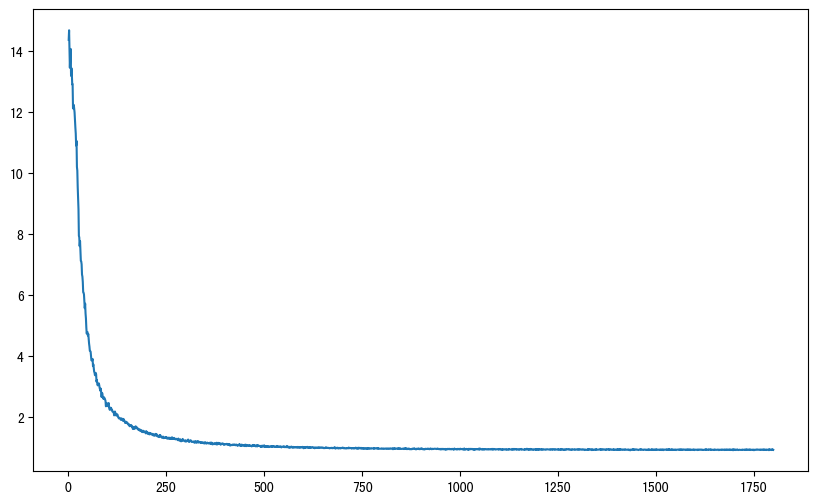

In [108]:
lr = 0.005
epoch = 1800
model1, ls_metric1 = train_loop(train_data1, epoch, lr)
plot_loss(ls_metric1)

Epoch: 0001, Loss: 17.97403
Epoch: 0002, Loss: 17.75246
Epoch: 0003, Loss: 18.10733
Epoch: 0004, Loss: 17.42535
Epoch: 0005, Loss: 17.87858
Epoch: 0006, Loss: 17.87749
Epoch: 0007, Loss: 17.14081
Epoch: 0008, Loss: 17.63864
Epoch: 0009, Loss: 16.69433
Epoch: 0010, Loss: 16.45306
Epoch: 0011, Loss: 16.98239
Epoch: 0012, Loss: 16.40958
Epoch: 0013, Loss: 16.11612
Epoch: 0014, Loss: 16.60811
Epoch: 0015, Loss: 16.37589
Epoch: 0016, Loss: 16.30913
Epoch: 0017, Loss: 16.32329
Epoch: 0018, Loss: 15.91325
Epoch: 0019, Loss: 15.59552
Epoch: 0020, Loss: 14.95574
Epoch: 0021, Loss: 15.44337
Epoch: 0022, Loss: 15.85991
Epoch: 0023, Loss: 15.18602
Epoch: 0024, Loss: 14.88715
Epoch: 0025, Loss: 14.88015
Epoch: 0026, Loss: 14.45170
Epoch: 0027, Loss: 14.39781
Epoch: 0028, Loss: 14.34901
Epoch: 0029, Loss: 14.84960
Epoch: 0030, Loss: 13.86356
Epoch: 0031, Loss: 13.68549
Epoch: 0032, Loss: 13.41618
Epoch: 0033, Loss: 13.69034
Epoch: 0034, Loss: 13.53006
Epoch: 0035, Loss: 13.39138
Epoch: 0036, Loss: 1

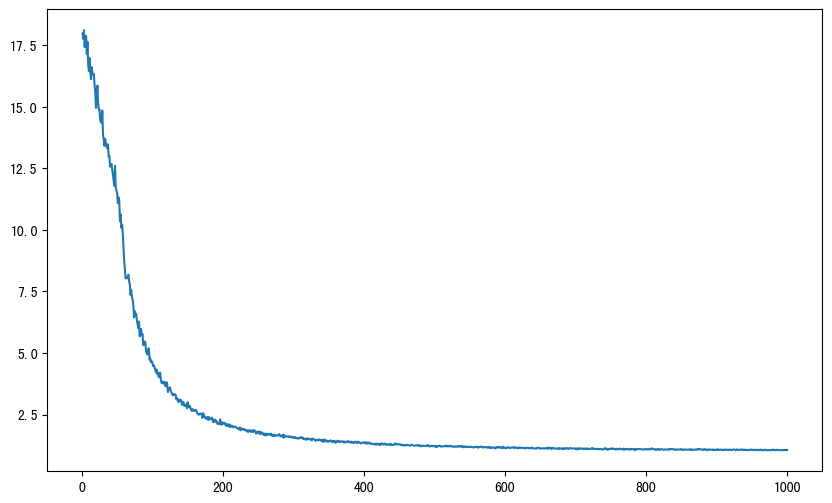

In [43]:
lr = 0.005
epoch = 1000
model2, ls_metric2 = train_loop(train_data2, epoch, lr)
plot_loss(ls_metric2)

Epoch: 0001, Loss: 14.14715
Epoch: 0002, Loss: 13.36140
Epoch: 0003, Loss: 12.93041
Epoch: 0004, Loss: 13.53121
Epoch: 0005, Loss: 12.67009
Epoch: 0006, Loss: 12.66998
Epoch: 0007, Loss: 13.12891
Epoch: 0008, Loss: 11.94293
Epoch: 0009, Loss: 11.42380
Epoch: 0010, Loss: 11.35104
Epoch: 0011, Loss: 11.86538
Epoch: 0012, Loss: 11.93950
Epoch: 0013, Loss: 11.19639
Epoch: 0014, Loss: 11.26685
Epoch: 0015, Loss: 10.77250
Epoch: 0016, Loss: 11.11706
Epoch: 0017, Loss: 10.49041
Epoch: 0018, Loss: 10.24252
Epoch: 0019, Loss: 10.36296
Epoch: 0020, Loss: 10.66913
Epoch: 0021, Loss: 10.06466
Epoch: 0022, Loss: 10.17671
Epoch: 0023, Loss: 9.97528
Epoch: 0024, Loss: 9.46553
Epoch: 0025, Loss: 9.91184
Epoch: 0026, Loss: 9.58087
Epoch: 0027, Loss: 8.95693
Epoch: 0028, Loss: 8.62715
Epoch: 0029, Loss: 8.74849
Epoch: 0030, Loss: 9.08295
Epoch: 0031, Loss: 8.12704
Epoch: 0032, Loss: 7.78250
Epoch: 0033, Loss: 8.82165
Epoch: 0034, Loss: 8.31180
Epoch: 0035, Loss: 7.67210
Epoch: 0036, Loss: 7.71319
Epoch:

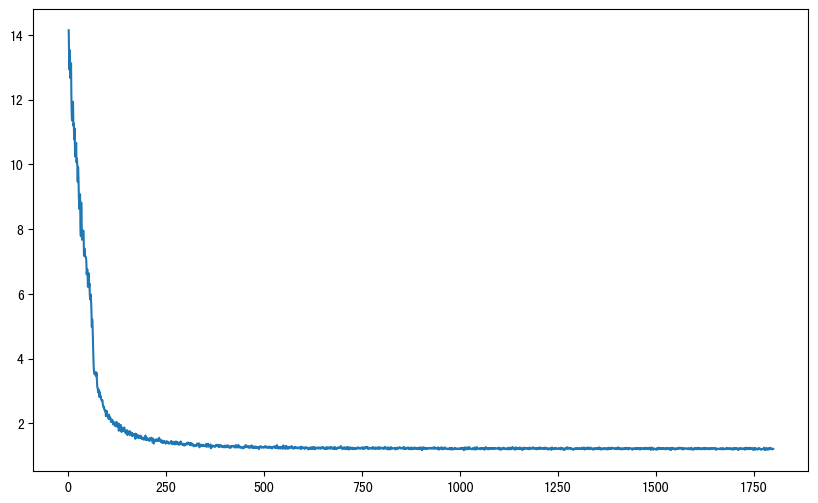

In [91]:
lr = 0.008
epoch = 1800
model3, ls_metric3 = train_loop(train_data3, epoch, lr)
plot_loss(ls_metric3)

In [109]:
test1_pred = predict(test_data1, model1)
pd.DataFrame({
    'id': df_test1['id'],
    'prob': test1_pred.tolist()
}).to_csv('test1_upload.csv', index=False)

In [44]:
test2_pred = predict(test_data2, model2)
pd.DataFrame({
    'id': df_test2['id'],
    'prob': test2_pred.tolist()
}).to_csv('test2_upload.csv', index=False)

In [92]:
test3_pred = predict(test_data3, model3)
pd.DataFrame({
    'id': df_test3['id'],
    'prob': test3_pred.tolist()
}).to_csv('test3_upload.csv', index=False)

## visualization